In [19]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt

import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot

import xarray as xr

from IPython.display import clear_output
from collections import OrderedDict
import itertools

In [20]:
# basedir = '\\\\depot.engr.oregonstate.edu\\users\\coe_apirate\\Windows.Documents\\Desktop\\Data'
basedir = 'C:\\Users\\aspit\\OneDrive\\OSU\\Raw Data'
# basedir = 'C://Users/coe_apirate/OneDrive/OSU/Raw Data'
fps = {
#     'si2' : os.path.join(basedir,'20190309\Silicon 2'),
    'bia_normalholder': os.path.join(basedir,'20190327\EPFL_Bi_2_Couplingtest'), 
    'bia_smallholder': os.path.join(basedir,'20190329\EPFL_BiA_2_coupling_smallholder'),
#     'empty': os.path.join(basedir,'20190326\Empty2'), 
#     'bia': os.path.join(basedir,'20190128\Bi_A_2'),
#     'bid': os.path.join(basedir,'20190201\Sample_D_2'),
#     'bic': os.path.join(basedir,'20190130\Sample Bi_C_2_2'),
#     'bib': os.path.join(basedir,'20190202\Sample Bi_B_2'),
#     'bhjua': os.path.join(basedir,'20190125\PH3TUA'),
#     'bhja': os.path.join(basedir,'20190127\P3HTA')   
}

In [21]:
da_sw1 = load.sweeps2ds({'bia_normalholder':fps['bia_normalholder']},regex = 'Sweep_run2_(\d+)mm_exp.csv', groupnames= ['dist'])['Vsignal(V)']
da_sw2 = load.sweeps2ds({'bia_smallholder':fps['bia_smallholder']},regex = 'Sweep_(\d+)mm_1_exp.csv', groupnames= ['dist'])['Vsignal(V)']

da_sw = xr.concat([da_sw1,da_sw2],'sample')

da_sw = da_sw.assign_coords(dist = [int(dist) for dist in da_sw.coords['dist']])

da_sw = da_sw.sortby('dist')

In [22]:
col = None if (len(da_sw.indexes['sample']) == 1)  else 'sample'
# row = None if (len(da_sw.indexes['direction']) == 1)  else 'direction'

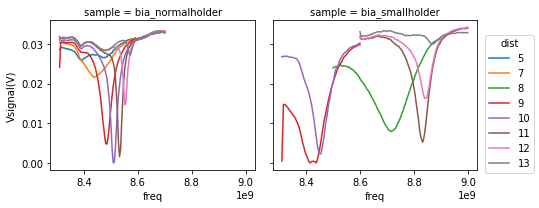

In [23]:
g = da_sw.plot(hue = 'dist', col = 'sample')

for ax in g.axes.flatten():
    plot.removena_axes(ax)



In [24]:
# da_sw_sampnum = da_sw.assign_coords(sample = range(len(da_sw.coords['sample'])))

In [25]:
# da_sw_sampnum.plot(col = 'dist')

In [26]:
das = []
das_bv = []

for samp in fps:
    direc = os.path.join(fps[samp],'FreqFluence')
    
    s_fps = load.freqfluence_flist(direc,file_re = '^(\d+)mm_Filter=\d+_Fluence=(.+?)_data.csv', file_groupnames = ['dist','fluence'],direction_used = False)

    da_fps = xr.DataArray.from_series(s_fps)
    das_dist = []
    das_bv_dist = []
    for dist in da_fps.coords['dist'].values:
        s_fps_dist = da_fps.sel(dist = dist).to_series().dropna()
        print('Loading data for ' + samp)
        s,backvs = load.freqfluence_load(s_fps_dist, sub_lowpow=False)

        print('Converting to Dataset')
        da = xr.DataArray.from_series(s)
        da = da.chunk({'time': 2000})
        da = da.expand_dims('sample')
        da['sample'] = [samp]
        da = da.expand_dims('dist')
        da['dist'] = [int(dist)]

        das_dist.append(da)

        da_bv = xr.DataArray.from_series(backvs)
        da_bv = da_bv.expand_dims('sample')
        da_bv['sample'] = [samp]
        da_bv = da_bv.expand_dims('dist')
        da_bv['dist'] = [int(dist)]
        das_bv_dist.append(da_bv)

    das_bv.append(xr.concat(das_bv_dist,'dist'))
    das.append(xr.concat(das_dist,'dist')) 
da_dv = xr.concat(das, dim = 'sample')
da_dv = da_dv*(-1) #voltage is flipped

da_dv.name = '$\Delta V$ (V)'
da_dv.attrs = dict(units = 'V', long_name = '$\Delta V$')

da_dv.coords['freq'].attrs = dict(units = 'Hz', long_name = 'Frequency')
da_dv.coords['fluence'].attrs = dict(units = '$\#/cm^2/pulse$', long_name = 'Fluence')
da_dv.coords['time'].attrs = dict(units = 'ns', long_name = 'Time')

da_bv = xr.concat(das_bv,dim = 'sample')

print('done')

no match for file 11mm_FluenceSweep.csv
Loading data for bia_smallholder
Converting to Dataset
Loading data for bia_smallholder
Converting to Dataset
Loading data for bia_smallholder
Converting to Dataset
Loading data for bia_smallholder
Converting to Dataset
done


In [27]:
da_dv = da_dv.sortby('dist')

In [28]:
%store da_dv
%store da_bv

Stored 'da_dv' (DataArray)
Stored 'da_bv' (DataArray)


In [29]:
da_dv = da_dv.load()

In [30]:
# da_dv.isel(sample =0, fluence = 0,direction = 0).dropna('dist','all').plot(col = 'dist', hue = 'freq')

In [31]:
col = None if (len(da_dv.indexes['sample']) == 1)  else 'sample'
row = None if (len(da_dv.indexes['direction']) == 1)  else 'direction'
timeslice = slice(0e-9,1000e-9)

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


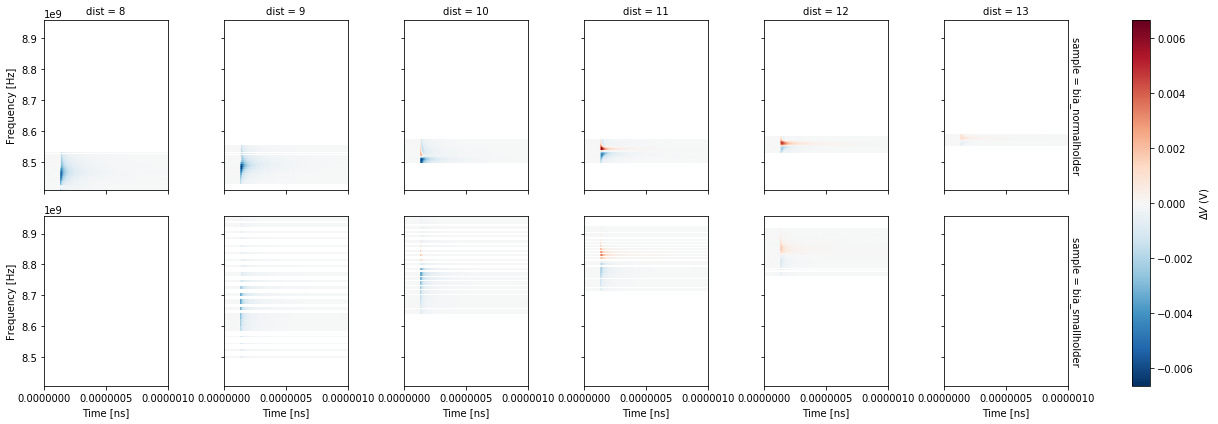

In [32]:
g = da_dv.isel(direction = 0).dropna('fluence','all').dropna('dist','all').dropna('freq','all').mean('fluence').sel(time = timeslice).plot(x = 'time', y = 'freq', col = 'dist', row = 'sample')

# axs = g.axes.flatten() if type(g.axes) == np.ndarray else [g.axes]
# for ax in axs:
#     ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

In [33]:
# def freq_offset(da):
#     freqs = da.dropna('freq','all').indexes['freq'].values
#     da = da.assign_coords(freq = da.indexes['freq'] - freqs[0])
#     return da

# da_dv_offset = da_dv.isel(sample = 0).groupby('dist').apply(freq_offset)

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


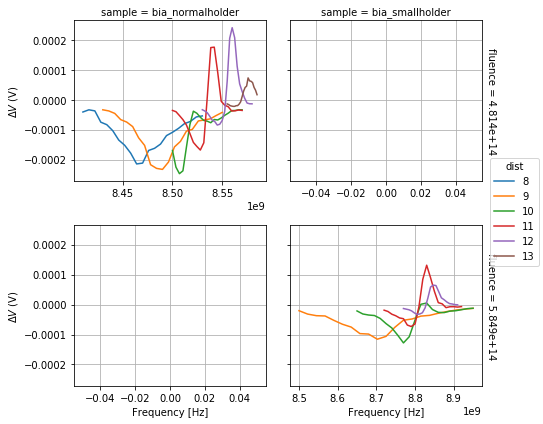

In [34]:
g = da_dv.isel(direction = 0).mean('time').dropna('fluence','all').dropna('dist','all').dropna('freq','all').plot( hue = 'dist', row = 'fluence',col = 'sample', sharex = False)

for ax in g.axes.flatten():
    plot.removena_axes(ax)
    ax.grid()

# for ln in lns:
#     plot.dropna_ln(ln)


In [35]:
da_sw = load.sweeps2ds(fps,regex = 'Sweep_beforelaser_(\d+)mm_final_exp.csv', groupnames= ['dist'])['Vsignal(V)']

da_sw = da_sw.assign_coords(dist = [int(dist) for dist in da_sw.coords['dist']])

da_sw = da_sw.sortby('dist')

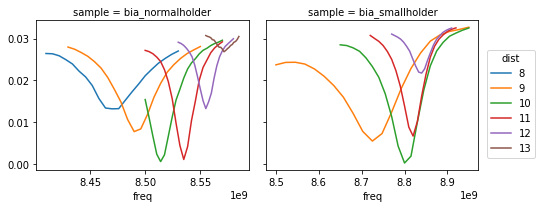

In [36]:
g = da_bv.isel(direction = 0).plot(hue = 'dist', col = 'sample', sharex = False)

for ax in g.axes.flatten():
    plot.removena_axes(ax)